In [1]:
from clawpack.pyclaw.solution import Solution
import numpy as np
import matplotlib.pyplot as plt
from clawpack import visclaw
from clawpack.visclaw.ianimate import ianimate
from nodepy import rk
import scipy.io
import os, sys
import scipy.integrate as integrate

# Import setup
from Num_Sol_2D_Acoustics import setup

### Exact solution

In [2]:
# Change here for different manufactured solutions
# Manufactures solution 
#-------------------------#
def d_int_p(x,y,t):
    return x*y**2/(2*t + 2) + y*(x**2 + 2*x)/(2*t + 2)

def d_int_u(x,y,t):
    return t*x**2*y/(2*t + 2)

def d_int_v(x,y,t):
    return t*x*y**2/(2*t + 2)

In [3]:
def Exact_Sol(X,Y,dx,dy,t):
    p_ex = (d_int_p(X+dx/2,Y+dy/2,t) + d_int_p(X-dx/2,Y-dy/2,t) - d_int_p(X+dx/2,Y-dy/2,t) - d_int_p(X-dx/2,Y+dy/2,t))/(dx*dy)
    u_ex = (d_int_u(X+dx/2,Y+dy/2,t) + d_int_u(X-dx/2,Y-dy/2,t) - d_int_u(X+dx/2,Y-dy/2,t) - d_int_u(X-dx/2,Y+dy/2,t))/(dx*dy)
    v_ex = (d_int_v(X+dx/2,Y+dy/2,t) + d_int_v(X-dx/2,Y-dy/2,t) - d_int_v(X+dx/2,Y-dy/2,t) - d_int_v(X-dx/2,Y+dy/2,t))/(dx*dy)
    
    return p_ex, u_ex, v_ex

In [4]:
def butcher_coeff(s,p,q,sch_no):
# Coefficients of Runge-Kutta method
#------------------------------#
    # Method 1: (3,3,1)
    if s == 3 and p == 3 and q == 1 and sch_no == 1:
        ssp33 = rk.loadRKM('SSP33')
        a = ssp33.A.astype('float64')
        b = ssp33.b.astype('float64')
        c = ssp33.c.astype('float64')
    # Method 2 (5,3,3)
    elif s == 5 and p == 3 and q == 3 and sch_no == 2:
#------------------------------#
        # Method 2: (5,3,3)
        a = np.array([[                  0,                 0,       0,              0,      0],
                      [               4/25,                 0,       0,              0,      0],
                      [       40646/132219,      47500/132219,       0,              0,      0],
                      [    -587499/3134080,     712975/626816,       0,              0,      0],
                      [ -12747373/12002547, 35703750/16635109, -90/731, 128000/3291693,      0]])

        b = np.array([24989/9120, -580625/144096, 103761/25840, -296720/76551, 43/20])
        c = np.sum(a,axis=1)
#------------------------------#
    # Method 3: (4,4,1)
    elif s == 4 and p == 4 and q == 1 and sch_no == 3:        
        rk4 = rk.loadRKM('RK44')
        a = rk4.A.astype('float64')
        b = rk4.b.astype('float64')
        c = rk4.c.astype('float64')
#------------------------------#
    # Method 4: (7,4,4)
    elif s == 7 and p == 4 and q == 4 and sch_no == 4:
        mat = scipy.io.loadmat('ExMthdAs7p4q4.mat') 
        a = np.array(mat['A']);b = np.array(mat['b'][0]);c = np.sum(a,axis=1)
#------------------------------#
    # Method 5: (7,5,1)
    elif s == 7 and p == 5 and q == 1 and sch_no == 5:
        dp5 = rk.loadRKM('DP5')
        a = dp5.A.astype('float64')
        b = dp5.b.astype('float64')
        c = dp5.c.astype('float64')
#------------------------------#
    # Method 6: (10,5,5)
    elif s == 10 and p == 5 and q == 5 and sch_no == 6: 
        mat = scipy.io.loadmat('ExMthdAs10p5q5.mat') 
        a = np.array(mat['A']);b = np.array(mat['b'].T)[0];c = np.sum(a,axis=1)
#------------------------------#
    return a,b,c

## Convergence test

In [5]:
def compute_err(N, s, p, q, sch_no, tfinal, cfl):
    a,b,c = butcher_coeff(s,p,q,sch_no)
    errs_p = []; errs_u = []; errs_v = [];
    for idx in range(len(N)):
        print(N[idx])
        claw = setup(mx=N[idx],my=N[idx],a=a,b=b,c=c,tfinal=tfinal, cfl = cfl)
        claw.run()
        frame = claw.frames[-1]; 
        xc = frame.grid.x.centers; dx = xc[1]-xc[0]
        yc = frame.grid.y.centers; dy = yc[1]-yc[0]
        X, Y = frame.state.p_centers; t = frame.t
        # exact sol
        p_ex, u_ex, v_ex = Exact_Sol(X,Y,dx,dy,t)
        # Numerical solution
        num_p = frame.q[0]; num_u = frame.q[1]; num_v = frame.q[2];
        # Compute error 
        err_p = np.max(np.max(np.abs(num_p - p_ex)))
        err_u = np.max(np.max(np.abs(num_u - u_ex)))
        err_v = np.max(np.max(np.abs(num_v - v_ex)))
        errs_p.append(err_p); errs_u.append(err_u); errs_v.append(err_v)
    return errs_p, errs_u, errs_v

In [6]:
N = np.array([[10,20,30,40,50,60,70,80,90,100],
              [10,20,30,40,50,60,70,80,90,100],
              [5,10,15,20,25,30,35,40,45,50],
              [5,10,15,20,25,30,35,40,45,50],
              [4,8,12,16,20,24,28,32,36,40],
              [4,8,12,16,20,24,28,32,36,40]]);

tfinal = 1; cfl = 0.45; DTs = cfl*(1./N)/3; 
S = [3,5,4,7,7,10];P =[3,3,4,4,5,5]; Q =[1,3,1,4,1,5]; SCH_NO = [1,2,3,4,5,6]
#SCH_NO = [1,2]; S = [3,5];P =[3,3]; Q =[1,3]
#SCH_NO = [3,4]; S = [4,7];P =[4,4]; Q =[1,4]
#SCH_NO = [5,6]; S = [7,10];P =[5,5]; Q =[1,5]
Err_p = np.zeros((len(SCH_NO),len(N[0])))
Err_u = np.zeros((len(SCH_NO),len(N[0])))
Err_v = np.zeros((len(SCH_NO),len(N[0])))

for i in range(len(SCH_NO)):
    print("(Method = (%d,%d,%d))"%(S[i], P[i], Q[i]))
    errs_p, errs_u, errs_v = compute_err(N[i], S[i], P[i], Q[i], SCH_NO[i], tfinal, cfl)
    Err_p[i,:] = errs_p; Err_u[i,:] = errs_u; Err_v[i,:] = errs_v

(Method = (3,3,1))
10
2023-09-05 11:58:41,780 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 11:58:41,797 INFO CLAW: Solution 1 computed for time t=0.100000
2023-09-05 11:58:41,815 INFO CLAW: Solution 2 computed for time t=0.200000
2023-09-05 11:58:41,835 INFO CLAW: Solution 3 computed for time t=0.300000
2023-09-05 11:58:41,853 INFO CLAW: Solution 4 computed for time t=0.400000
2023-09-05 11:58:41,872 INFO CLAW: Solution 5 computed for time t=0.500000
2023-09-05 11:58:41,889 INFO CLAW: Solution 6 computed for time t=0.600000
2023-09-05 11:58:41,908 INFO CLAW: Solution 7 computed for time t=0.700000
2023-09-05 11:58:41,926 INFO CLAW: Solution 8 computed for time t=0.800000
2023-09-05 11:58:41,944 INFO CLAW: Solution 9 computed for time t=0.900000
2023-09-05 11:58:41,963 INFO CLAW: Solution 10 computed for time t=1.000000
20
2023-09-05 11:58:41,967 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 11:58:42,016 INFO CLAW: Solution 1 computed for time t=0.100000

2023-09-05 11:59:18,773 INFO CLAW: Solution 10 computed for time t=1.000000
(Method = (5,3,3))
10
2023-09-05 11:59:18,778 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 11:59:18,806 INFO CLAW: Solution 1 computed for time t=0.100000
2023-09-05 11:59:18,834 INFO CLAW: Solution 2 computed for time t=0.200000
2023-09-05 11:59:18,861 INFO CLAW: Solution 3 computed for time t=0.300000
2023-09-05 11:59:18,889 INFO CLAW: Solution 4 computed for time t=0.400000
2023-09-05 11:59:18,916 INFO CLAW: Solution 5 computed for time t=0.500000
2023-09-05 11:59:18,943 INFO CLAW: Solution 6 computed for time t=0.600000
2023-09-05 11:59:18,971 INFO CLAW: Solution 7 computed for time t=0.700000
2023-09-05 11:59:18,998 INFO CLAW: Solution 8 computed for time t=0.800000
2023-09-05 11:59:19,027 INFO CLAW: Solution 9 computed for time t=0.900000
2023-09-05 11:59:19,055 INFO CLAW: Solution 10 computed for time t=1.000000
20
2023-09-05 11:59:19,059 INFO CLAW: Solution 0 computed for time t=0.00000

2023-09-05 12:00:18,080 INFO CLAW: Solution 9 computed for time t=0.900000
2023-09-05 12:00:19,639 INFO CLAW: Solution 10 computed for time t=1.000000
(Method = (4,4,1))
5
2023-09-05 12:00:19,660 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:00:19,674 INFO CLAW: Solution 1 computed for time t=0.100000
2023-09-05 12:00:19,685 INFO CLAW: Solution 2 computed for time t=0.200000
2023-09-05 12:00:19,696 INFO CLAW: Solution 3 computed for time t=0.300000
2023-09-05 12:00:19,706 INFO CLAW: Solution 4 computed for time t=0.400000
2023-09-05 12:00:19,716 INFO CLAW: Solution 5 computed for time t=0.500000
2023-09-05 12:00:19,727 INFO CLAW: Solution 6 computed for time t=0.600000
2023-09-05 12:00:19,738 INFO CLAW: Solution 7 computed for time t=0.700000
2023-09-05 12:00:19,749 INFO CLAW: Solution 8 computed for time t=0.800000
2023-09-05 12:00:19,759 INFO CLAW: Solution 9 computed for time t=0.900000
2023-09-05 12:00:19,772 INFO CLAW: Solution 10 computed for time t=1.000000
10

2023-09-05 12:00:32,080 INFO CLAW: Solution 8 computed for time t=0.800000
2023-09-05 12:00:32,401 INFO CLAW: Solution 9 computed for time t=0.900000
2023-09-05 12:00:32,729 INFO CLAW: Solution 10 computed for time t=1.000000
(Method = (7,4,4))
5
2023-09-05 12:00:32,734 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:00:32,751 INFO CLAW: Solution 1 computed for time t=0.100000
2023-09-05 12:00:32,769 INFO CLAW: Solution 2 computed for time t=0.200000
2023-09-05 12:00:32,786 INFO CLAW: Solution 3 computed for time t=0.300000
2023-09-05 12:00:32,803 INFO CLAW: Solution 4 computed for time t=0.400000
2023-09-05 12:00:32,820 INFO CLAW: Solution 5 computed for time t=0.500000
2023-09-05 12:00:32,837 INFO CLAW: Solution 6 computed for time t=0.600000
2023-09-05 12:00:32,854 INFO CLAW: Solution 7 computed for time t=0.700000
2023-09-05 12:00:32,871 INFO CLAW: Solution 8 computed for time t=0.800000
2023-09-05 12:00:32,888 INFO CLAW: Solution 9 computed for time t=0.900000
202

2023-09-05 12:00:53,635 INFO CLAW: Solution 7 computed for time t=0.700000
2023-09-05 12:00:54,208 INFO CLAW: Solution 8 computed for time t=0.800000
2023-09-05 12:00:54,768 INFO CLAW: Solution 9 computed for time t=0.900000
2023-09-05 12:00:55,388 INFO CLAW: Solution 10 computed for time t=1.000000
(Method = (7,5,1))
4
2023-09-05 12:00:55,408 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:00:55,420 INFO CLAW: Solution 1 computed for time t=0.100000
2023-09-05 12:00:55,433 INFO CLAW: Solution 2 computed for time t=0.200000
2023-09-05 12:00:55,447 INFO CLAW: Solution 3 computed for time t=0.300000
2023-09-05 12:00:55,474 INFO CLAW: Solution 4 computed for time t=0.400000
2023-09-05 12:00:55,497 INFO CLAW: Solution 5 computed for time t=0.500000
2023-09-05 12:00:55,511 INFO CLAW: Solution 6 computed for time t=0.600000
2023-09-05 12:00:55,525 INFO CLAW: Solution 7 computed for time t=0.700000
2023-09-05 12:00:55,538 INFO CLAW: Solution 8 computed for time t=0.800000
202

2023-09-05 12:01:09,200 INFO CLAW: Solution 6 computed for time t=0.600000
2023-09-05 12:01:09,559 INFO CLAW: Solution 7 computed for time t=0.700000
2023-09-05 12:01:09,915 INFO CLAW: Solution 8 computed for time t=0.800000
2023-09-05 12:01:10,273 INFO CLAW: Solution 9 computed for time t=0.900000
2023-09-05 12:01:10,630 INFO CLAW: Solution 10 computed for time t=1.000000
(Method = (10,5,5))
4
2023-09-05 12:01:10,635 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:01:10,649 INFO CLAW: Solution 1 computed for time t=0.100000
2023-09-05 12:01:10,669 INFO CLAW: Solution 2 computed for time t=0.200000
2023-09-05 12:01:10,686 INFO CLAW: Solution 3 computed for time t=0.300000
2023-09-05 12:01:10,702 INFO CLAW: Solution 4 computed for time t=0.400000
2023-09-05 12:01:10,717 INFO CLAW: Solution 5 computed for time t=0.500000
2023-09-05 12:01:10,733 INFO CLAW: Solution 6 computed for time t=0.600000
2023-09-05 12:01:10,749 INFO CLAW: Solution 7 computed for time t=0.700000
20

2023-09-05 12:01:29,700 INFO CLAW: Solution 5 computed for time t=0.500000
2023-09-05 12:01:30,212 INFO CLAW: Solution 6 computed for time t=0.600000
2023-09-05 12:01:30,722 INFO CLAW: Solution 7 computed for time t=0.700000
2023-09-05 12:01:31,234 INFO CLAW: Solution 8 computed for time t=0.800000
2023-09-05 12:01:31,746 INFO CLAW: Solution 9 computed for time t=0.900000
2023-09-05 12:01:32,271 INFO CLAW: Solution 10 computed for time t=1.000000


#### Saving data

In [7]:
folder_name = "LinearAcoustics_2D_ConvgData/"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [8]:
#Convergence plot data
np.save("./%s/Acoustics_2D_dts_CFL_%1.2f_T_%1.1f.npy"%(folder_name,cfl,tfinal),DTs)
np.save("./%s/Acoustics_2D_Err_p_CFL_%1.2f_T_%1.1f.npy"%(folder_name,cfl,tfinal),Err_p)
np.save("./%s/Acoustics_2D_Err_u_CFL_%1.2f_T_%1.1f.npy"%(folder_name,cfl,tfinal),Err_u)
np.save("./%s/Acoustics_2D_Err_v_CFL_%1.2f_T_%1.1f.npy"%(folder_name,cfl,tfinal),Err_v)

#### Convergence plot

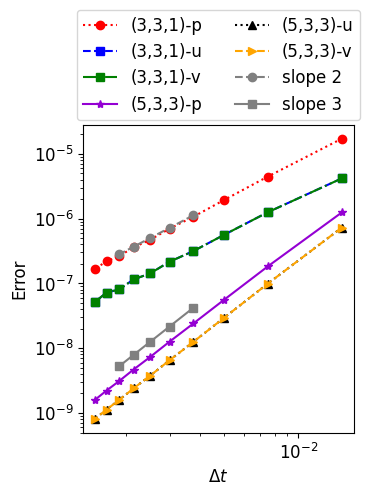

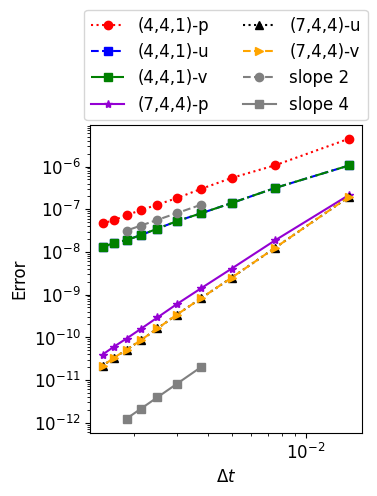

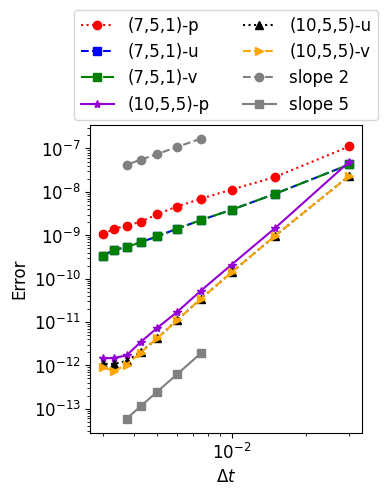

In [11]:
#plotting
Marks = ['o','s','+','*','^','>']
lines = [":","--","-.","-",":","--"]
colors = ["red", "blue", "green" ,"darkviolet","black","orange"]

Sl = [2,3,2,4,2,5]; Coeff = [8e-2,8e-1,9e-3,1e-1,3e-3,8e-2]

font = {#'family' : 'normal',
'weight' : 'normal',
'size'   : 12}
plt.rc('font', **font) 

st = 3; en = 8;

for i in range(3):
    fig = plt.figure(figsize = (3.5, 4))
    plt.plot(DTs[i],Err_p[2*i,:],color=colors[0], marker=Marks[0], linestyle=lines[0],label = "(%d,%d,%d)-p"%(S[2*i],P[2*i],Q[2*i]))
    plt.plot(DTs[i],Err_u[2*i,:],color=colors[1], marker=Marks[1], linestyle=lines[1],label = "(%d,%d,%d)-u"%(S[2*i],P[2*i],Q[2*i]))
    plt.plot(DTs[i],Err_v[2*i,:],color=colors[2], marker=Marks[1], linestyle=lines[2],label = "(%d,%d,%d)-v"%(S[2*i],P[2*i],Q[2*i]))

    plt.plot(DTs[i],Err_p[2*i+1,:],color=colors[3], marker=Marks[3], linestyle=lines[3],label = "(%d,%d,%d)-p"%(S[2*i+1],P[2*i+1],Q[2*i+1]))
    plt.plot(DTs[i],Err_u[2*i+1,:],color=colors[4], marker=Marks[4], linestyle=lines[4],label = "(%d,%d,%d)-u"%(S[2*i+1],P[2*i+1],Q[2*i+1]))
    plt.plot(DTs[i],Err_v[2*i+1,:],color=colors[5], marker=Marks[5], linestyle=lines[5],label = "(%d,%d,%d)-v"%(S[2*i+1],P[2*i+1],Q[2*i+1]))

    plt.plot(DTs[i][st:en],Coeff[2*i]*DTs[i][st:en]**Sl[2*i], "--o", color="gray",label='slope %d'%(Sl[2*i]))
    plt.plot(DTs[i][st:en], Coeff[2*i+1]*DTs[i][st:en]**Sl[2*i+1], "-s", color="gray",label='slope %d'%(Sl[2*i+1]))

    plt.xscale("log"); plt.yscale("log"); plt.xlabel('$\Delta t$'); plt.ylabel('Error')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.4),ncol=2)
